In [2]:
# Caso de Estudio: Predicción del Precio del Oro con Redes LSTM (versión mejorada)

## 1. Descubrimiento del Caso de Negocio
# Contexto del proyecto: Commodity Analytics busca predecir el precio del oro (XAU/USD)
# utilizando datos históricos y variables macroeconómicas para optimizar decisiones de inversión.

## 2. Procesamiento de Datos
import yfinance as yf
import pandas as pd
import numpy as np

# Descargar datos históricos desde Yahoo Finance
oro = yf.download("GC=F", start="2010-01-01")
dxy = yf.download("DX-Y.NYB", start="2010-01-01")
bonos = yf.download("^TNX", start="2010-01-01")
tip = yf.download("TIP", start="2010-01-01")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:

# Unión de datasets
df = pd.concat([oro['Close'], dxy['Close'], bonos['Close'], tip['Close']], axis=1).dropna()
df.columns = ['Oro', 'DXY', 'Bonos', 'TIP']

# Características derivadas
df['Ratio_Oro_DXY'] = df['Oro'] / df['DXY']
df['Inflacion_implicita'] = df['TIP'].pct_change()
df['Tasa_real'] = df['Bonos'] - df['Inflacion_implicita']
df['SMA200'] = df['Oro'].rolling(window=200).mean()
df['Bollinger_up'] = df['Oro'].rolling(window=20).mean() + 2*df['Oro'].rolling(window=20).std()
df['Bollinger_down'] = df['Oro'].rolling(window=20).mean() - 2*df['Oro'].rolling(window=20).std()
df = df.dropna()

# Nuevo objetivo: retorno logarítmico como target
df['retorno_log'] = np.log(df['Oro'] / df['Oro'].shift(1))
df = df.dropna()
# Nuevo objetivo: retorno logarítmico como target
df['retorno_log'] = np.log(df['Oro'] / df['Oro'].shift(1))
df = df.dropna()


In [11]:
# Separar features (todo menos el target) y target (retorno)
features = df.drop(columns=['retorno_log'])
target = df['retorno_log']

# Escalado solo de las features
scaler = RobustScaler()
features_scaled = scaler.fit_transform(features)

# Reconstrucción del DataFrame con target no escalado
df_scaled = pd.DataFrame(features_scaled, columns=features.columns, index=features.index)
df_scaled['retorno_log'] = target

# División por fechas reales
train_df = df_scaled.loc['2014':'2022']
val_df   = df_scaled.loc['2022':'2023']
test_df  = df_scaled.loc['2024':]


In [13]:

## 3. División de datos por fechas reales
train_df = df.loc['2014':'2022']
val_df = df.loc['2022':'2023']
test_df = df.loc['2024':]

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

def crear_secuencias(df, look_back=90):
    data = df.values
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:i + look_back, :-1])  # todas las features
        Y.append(data[i + look_back, -1])     # retorno logarítmico como target
    return np.array(X), np.array(Y)


look_back = 90
horizon = 5
X_train, Y_train = crear_secuencias(train_df)
X_val, Y_val = crear_secuencias(val_df)
X_test, Y_test = crear_secuencias(test_df)




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import Huber

model = Sequential([
    LSTM(192, return_sequences=True, input_shape=(look_back, X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.35),
    LSTM(96),
    BatchNormalization(),
    Dense(1)  # <-- predicción de retorno a 1 día
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [17]:
## 5. Entrenamiento
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_val, Y_val))

## 6. Evaluación del Modelo
preds = model.predict(X_test)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick


# Crear DataFrame para evaluación
df_eval = pd.DataFrame({
    'Real': Y_test.flatten(),
    'Predicción': preds.flatten()
})
df_eval['Error'] = df_eval['Real'] - df_eval['Predicción']
df_eval['Error_Abs'] = df_eval['Error'].abs()
df_eval['Error_Porc'] = df_eval['Error_Abs'] / df_eval['Real'] * 100


Epoch 1/50


68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.2377 - mae: 0.4969 - val_loss: 0.0056 - val_mae: 0.0959
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0082 - mae: 0.0998 - val_loss: 0.0196 - val_mae: 0.1855
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0044 - mae: 0.0729 - val_loss: 0.0266 - val_mae: 0.2030
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0013 - mae: 0.0413 - val_loss: 0.0367 - val_mae: 0.2480
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 9.8261e-04 - mae: 0.0341 - val_loss: 0.0155 - val_mae: 0.1496
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 7.2467e-04 - mae: 0.0300 - val_loss: 0.0096 - val_mae: 0.1244
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 9.0306e-04 - mae: 0.0338 - val_loss: 0.0028 - val_mae: 0.0636
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 5.1104e-04 - mae: 0.0250 - val_loss: 0.0012 - val_mae: 0.0396
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - lo

In [19]:
df_eval_clean = df_eval[df_eval['Real'].abs() > 0.001]


RMSE: 0.02255793545647847
MAE: 0.020186227327177928
MAPE (%): -23.391279818427925
Precisión direccional: 49.361702127659576 %


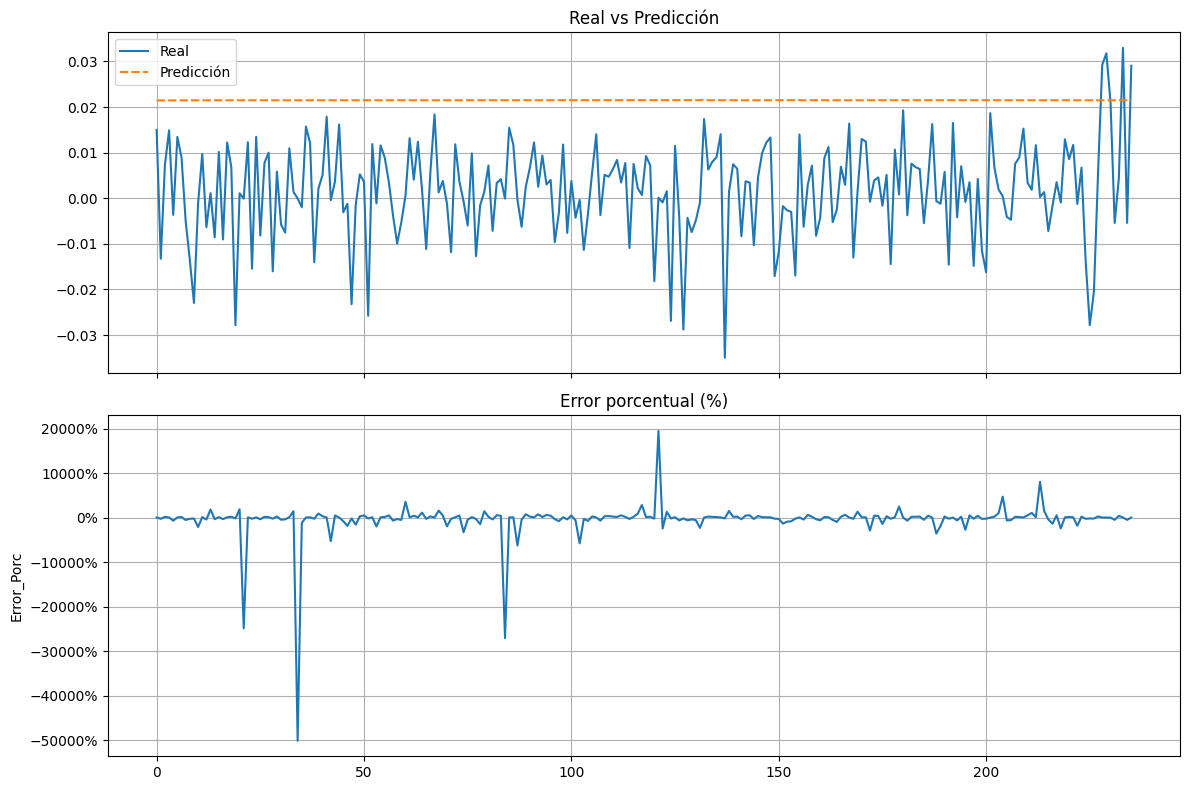

In [20]:

# Métricas clave
rmse = np.sqrt(np.mean(df_eval['Error']**2))
mae = np.mean(df_eval['Error_Abs'])
mape = np.mean(df_eval_clean['Error_Porc'])

directional_accuracy = np.mean(
    np.sign(np.diff(df_eval['Real'])) == np.sign(np.diff(df_eval['Predicción']))
) * 100

# Mostrar métricas
print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE (%):", mape)
print("Precisión direccional:", directional_accuracy, "%")

# Gráfico comparativo
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
sns.lineplot(data=df_eval[['Real', 'Predicción']], ax=axs[0])
axs[0].set_title("Real vs Predicción")
axs[0].grid(True)

sns.lineplot(data=df_eval['Error_Porc'], ax=axs[1])
axs[1].set_title("Error porcentual (%)")
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter())
axs[1].grid(True)
plt.tight_layout()


In [24]:
print("Target real (Y_test): min =", Y_test.min(), "max =", Y_test.max())
print("Predicción: min =", preds.min(), "max =", preds.max())


Target real (Y_test): min = -0.03495948190340738 max = 0.03297325457193712
Predicción: min = 0.021440629 max = 0.021615718


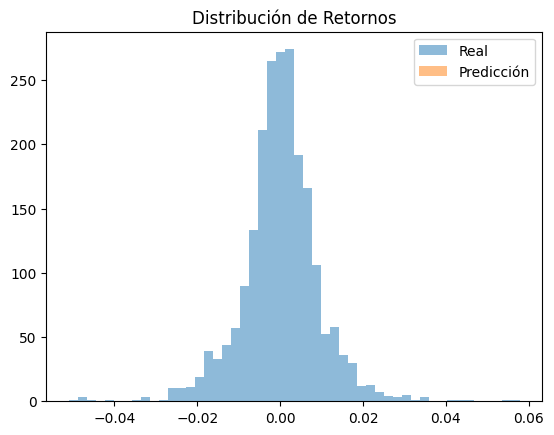

In [25]:
import matplotlib.pyplot as plt
plt.hist(Y_train, bins=50, alpha=0.5, label='Real')
plt.hist(preds, bins=50, alpha=0.5, label='Predicción')
plt.legend()
plt.title('Distribución de Retornos')
plt.show()


In [ ]:
print("Estadísticas del target real (Y_train):")
print("  Min:", Y_train.min(), "| Max:", Y_train.max(), "| Media:", Y_train.mean())

print("Estadísticas de la predicción (preds):")
print("  Min:", preds.min(), "| Max:", preds.max(), "| Media:", preds.mean())


Estadísticas del target real (Y_train):
  Min: -0.051069383720258016 | Max: 0.05777508425392426 | Media: 0.00015634799659247934
Estadísticas de la predicción (preds):
  Min: 0.021440629 | Max: 0.021615718 | Media: 0.02147667


In [ ]:

## 7. Guardar modelo y escalador
model.save('modelo_oro_lstm_mejorado.h5')
import joblib
joblib.dump(scaler, 'scaler_robust_mejorado.pkl')
